# AlexNet Implementation

### 1. Imports & Setup

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import AlexNet_Weights
from torch.utils.data import DataLoader, random_split, ConcatDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
import json


### 2. Device and Transforms

In [15]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Common transforms (MNIST → 3-channel 112×112)
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


Device: cuda


### 3. Load and Split Dataset

In [16]:
# Download and combine MNIST (train + test)
trainset_orig = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset_orig  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

full_dataset = ConcatDataset([trainset_orig, testset_orig])  # total 70k
n = len(full_dataset)
train_size = int(0.7 * n)
val_size   = int(0.15 * n)
test_size  = n - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("Sizes -> Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))


Sizes -> Train: 49000 Val: 10500 Test: 10500


### 4. Prepare Pretrained AlexNet

In [28]:
def prepare_alexnet(num_classes=10):
    model = models.alexnet(weights=AlexNet_Weights.DEFAULT)

    # Freeze feature extractor
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace classifier output layer
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    return model

alexnet = prepare_alexnet(num_classes=10).to(device)


### 5. Training & Validation Function

In [29]:
def train_and_validate(model, train_loader, val_loader, num_epochs=5, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr)

    train_losses, val_losses, epoch_times = [], [], []

    for epoch in range(num_epochs):
        start_time = time.time()

        # ---- Training ----
        model.train()
        train_loss_sum = 0.0
        total_train = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * imgs.size(0)
            total_train += imgs.size(0)

        train_loss = train_loss_sum / total_train

        # ---- Validation ----
        model.eval()
        val_loss_sum = 0.0
        total_val = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item() * imgs.size(0)
                total_val += imgs.size(0)

        val_loss = val_loss_sum / total_val
        epoch_time = time.time() - start_time

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}  Time: {epoch_time:.1f}s")

    return model, train_losses, val_losses


### 6. Train AlexNet

In [ ]:
num_epochs = 20  
alexnet, train_losses, val_losses = train_and_validate(alexnet, train_loader, val_loader, num_epochs=num_epochs)

Epoch 1/20  Train Loss: 0.2604  Val Loss: 0.1242  Time: 58.9s
Epoch 2/20  Train Loss: 0.1790  Val Loss: 0.1184  Time: 58.9s
Epoch 3/20  Train Loss: 0.1646  Val Loss: 0.1137  Time: 58.6s
Epoch 4/20  Train Loss: 0.1403  Val Loss: 0.0706  Time: 59.2s
Epoch 5/20  Train Loss: 0.1210  Val Loss: 0.0743  Time: 59.0s
Epoch 6/20  Train Loss: 0.1274  Val Loss: 0.0721  Time: 59.1s
Epoch 7/20  Train Loss: 0.1255  Val Loss: 0.0643  Time: 59.2s
Epoch 8/20  Train Loss: 0.1156  Val Loss: 0.0667  Time: 59.3s
Epoch 9/20  Train Loss: 0.1085  Val Loss: 0.0656  Time: 59.1s
Epoch 10/20  Train Loss: 0.1070  Val Loss: 0.0579  Time: 59.4s
Epoch 11/20  Train Loss: 0.0942  Val Loss: 0.0608  Time: 58.9s
Epoch 12/20  Train Loss: 0.0986  Val Loss: 0.0599  Time: 58.8s
Epoch 13/20  Train Loss: 0.0952  Val Loss: 0.0631  Time: 58.9s
Epoch 14/20  Train Loss: 0.0856  Val Loss: 0.0573  Time: 59.3s
Epoch 15/20  Train Loss: 0.0846  Val Loss: 0.0615  Time: 59.5s
Epoch 16/20  Train Loss: 0.0891  Val Loss: 0.0550  Time: 58.7s
E

### 7. Evaluate Model

In [20]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    return {"accuracy": acc, "precision": prec, "recall": rec, "confusion_matrix": cm}

alex_eval = evaluate_model(alexnet, test_loader)

print(f"Accuracy : {alex_eval['accuracy']*100:.2f}%")
print(f"Precision: {alex_eval['precision']*100:.2f}%")
print(f"Recall   : {alex_eval['recall']*100:.2f}%")
print("Confusion Matrix:\n", alex_eval['confusion_matrix'])


Accuracy : 98.43%
Precision: 98.45%
Recall   : 98.41%
Confusion Matrix:
 [[1057    0    1    0    0    0    1    0    1    0]
 [   0 1098    0    0    0    0    1    1    0    0]
 [   1    2 1048    2    1    1    0    7    3    3]
 [   3    0    6 1046    0    4    0    6    3    3]
 [   0    2    0    0 1023    0    1    1    0    4]
 [   4    1    1    7    0  911    3    1    4    3]
 [   3    5    0    0    7    0  966    0    0    0]
 [   0    3    4    2    3    0    0 1128    1    7]
 [   0    1    2    6    9    1    4    0  970    4]
 [   4    0    0    2    9    0    0    2    4 1088]]


### 8. Save Training Log

In [21]:
summary = {
    "alexnet": {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_metrics": {
            "accuracy": alex_eval["accuracy"],
            "precision": alex_eval["precision"],
            "recall": alex_eval["recall"]
        }
    }
}

with open("alexnet_finetune_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Summary saved as alexnet_finetune_summary.json")


Summary saved as alexnet_finetune_summary.json


### 9. Import Visualization Libraies

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

### 10. Plot Training & validation Loss

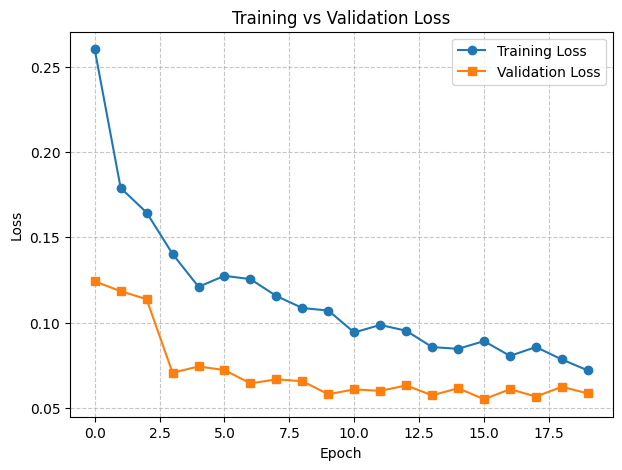

In [23]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(7,5))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_loss_curves(train_losses, val_losses)


### 11. Confusion Matrix Visualization

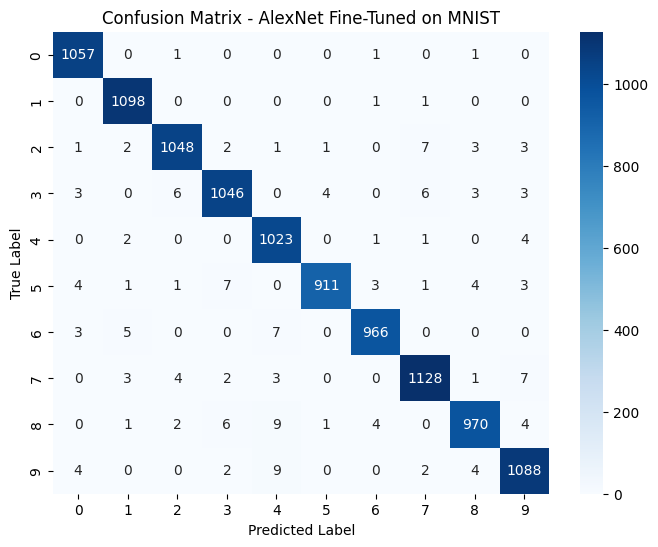

In [24]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - AlexNet Fine-Tuned on MNIST")
    plt.show()

plot_confusion_matrix(alex_eval['confusion_matrix'], class_names=[str(i) for i in range(10)])


### 12. Precision, Recall, F1 pre class

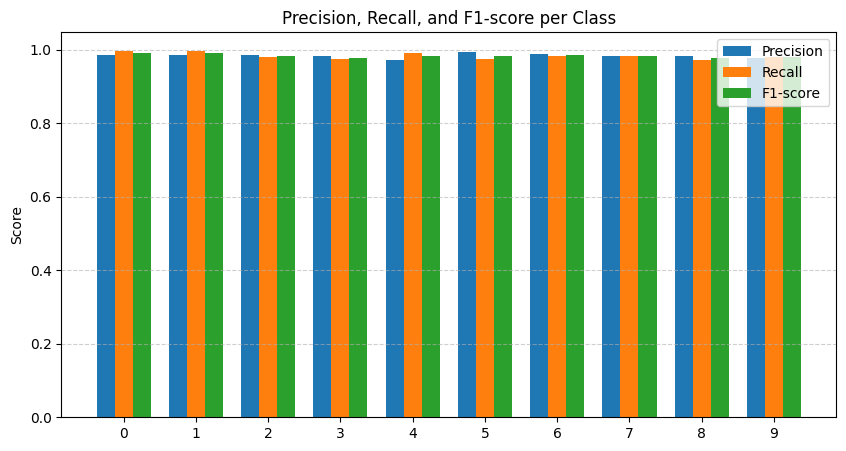

In [25]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate per-class metrics
prec, rec, f1, _ = precision_recall_fscore_support(
    np.array(list(alex_eval["confusion_matrix"].sum(axis=1))),
    np.array(list(alex_eval["confusion_matrix"].sum(axis=0))),
    average=None, zero_division=0
)
# Classification_report
y_true, y_pred = [], []
alexnet.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = alexnet(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

report = classification_report(y_true, y_pred, output_dict=True)

# Convert to dict for plotting
labels = list(report.keys())[:-3]  # ignore avg rows
precisions = [report[l]['precision'] for l in labels]
recalls = [report[l]['recall'] for l in labels]
f1s = [report[l]['f1-score'] for l in labels]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - width, precisions, width, label='Precision')
plt.bar(x, recalls, width, label='Recall')
plt.bar(x + width, f1s, width, label='F1-score')
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score per Class")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### 13. Summary Report Prinout

In [26]:
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, digits=4))


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9860    0.9972    0.9916      1060
           1     0.9874    0.9982    0.9928      1100
           2     0.9868    0.9813    0.9840      1068
           3     0.9822    0.9767    0.9794      1071
           4     0.9724    0.9922    0.9822      1031
           5     0.9935    0.9743    0.9838       935
           6     0.9898    0.9847    0.9872       981
           7     0.9843    0.9826    0.9834      1148
           8     0.9838    0.9729    0.9783       997
           9     0.9784    0.9811    0.9797      1109

    accuracy                         0.9843     10500
   macro avg     0.9845    0.9841    0.9843     10500
weighted avg     0.9843    0.9843    0.9843     10500



### 14. Save the model

In [ ]:
from google.colab import files

# Save trained model
torch.save(alexnet.state_dict(), 'alexnet_model.pth')

# Download to local machine
files.download('alexnet_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>